In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [ ]:
hd_pct = 0.001

params = [
          {
            "filtered": True,
            "fx_filtered": True,
            "topn": 1,
            "top_fx": 1,
            "top_cx": 2,
            "only_fx": True,
            "enbale_industry": False,
            "empty_priority": True
        }
        ]

In [4]:
def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [5]:
def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False):
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == 1].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == 1].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == 1].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


In [6]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [7]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502' ]
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '中位孕线低吸') and stock_rank <= 10 " % db_name
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,994,2024-09-04,低吸,中位孕线低吸,600114.XSHG,东睦股份,1,"000036.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885520.DDBK,885785.DDBK,885537.DDBK,885806.DDB...",980365.ZHBK,...,中位孕线低吸,-60.89,28.61,65,-61.66,7.50,45,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:44:21
1,1087,2024-09-06,低吸,中位孕线低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位孕线低吸,26.50,120.66,13,-7.85,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
2,1088,2024-09-06,低吸,中位孕线低吸,600552.XSHG,凯盛科技,2,"000036.BKDL,000035.BKDL,000006.BKDL,000037.BKD...","885520.DDBK,886021.DDBK,885710.DDBK,885806.DDB...",980357.ZHBK,...,中位孕线低吸,26.50,120.66,13,-7.85,53.47,31,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:46:29
3,1424,2024-09-20,低吸,中位孕线低吸,001236.XSHE,弘业期货,1,"000038.BKDL,000018.BKDL,000015.BKDL,000017.BKDL","885694.DDBK,886021.DDBK,885413.DDBK,885570.DDB...","980360.ZHBK,980341.ZHBK",...,中位孕线低吸,-11.77,1.13,47,-48.45,0.29,55,"{""9A0001"": {""realShortLineScore"": 2.69, ""realT...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:55:02
4,1583,2024-09-26,低吸,中位孕线低吸,600619.XSHG,海立股份,1,,,,...,中位孕线低吸,35.99,-21.26,39,3.05,6.27,42,"{""9A0001"": {""realShortLineScore"": 89.66, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 17:59:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,3116,2025-02-26,低吸,中位孕线低吸,603118.XSHG,共进股份,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,...,中位孕线低吸,91.88,-6.50,6,53.62,-0.05,11,"{""9A0001"": {""realShortLineScore"": 36.86, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:32:36
159,3164,2025-02-27,低吸,中位孕线低吸,002824.XSHE,和胜股份,1,,,,...,中位孕线低吸,154.11,53.00,5,70.18,2.89,11,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:33:38
160,3165,2025-02-27,低吸,中位孕线低吸,002164.XSHE,宁波东力,2,"000035.BKDL,000004.BKDL,000009.BKDL,000033.BKDL","885924.DDBK,885993.DDBK,885641.DDBK,886008.DDB...",980365.ZHBK,...,中位孕线低吸,154.11,53.00,5,70.18,2.89,11,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:33:38
161,3166,2025-02-27,低吸,中位孕线低吸,000678.XSHE,襄阳轴承,3,"000015.BKDL,000027.BKDL,000013.BKDL,000033.BKDL","885743.DDBK,886008.DDBK,885835.DDBK,885431.DDB...",980372.ZHBK,...,中位孕线低吸,154.11,53.00,5,70.18,2.89,11,"{""9A0001"": {""realShortLineScore"": 43.12, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-28 17:33:38


In [8]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']
combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10528\1079973233.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-04,994,低吸,中位孕线低吸,600114.XSHG,东睦股份,1,"000036.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885520.DDBK,885785.DDBK,885537.DDBK,885806.DDB...",980365.ZHBK,1,...,28.61,65,-61.66,7.50,45,2025-02-15 17:44:21,-0.036923,-0.037923,-0.046154,-0.047154
2024-09-26,1583,低吸,中位孕线低吸,600619.XSHG,海立股份,1,,,,-1,...,-21.26,39,3.05,6.27,42,2025-02-15 17:59:23,0.078484,0.077484,0.081191,0.080191
2024-10-23,655,低吸,中位孕线低吸,002762.XSHE,金发拉比,1,,,,-1,...,-17.56,20,96.56,-21.06,21,2025-02-15 18:15:17,0.000000,-0.001000,0.004104,0.003104
2024-10-31,1042,低吸,中位孕线低吸,002762.XSHE,金发拉比,1,,,,-1,...,4.00,32,109.66,-6.89,32,2025-02-15 18:23:04,-0.022556,-0.023556,-0.100251,-0.101251
2024-11-11,782,低吸,中位孕线低吸,002418.XSHE,康盛股份,3,,,,-1,...,-86.61,63,52.27,-21.65,44,2025-02-15 18:33:11,0.021818,0.020818,-0.025455,-0.026455
2024-11-12,887,低吸,中位孕线低吸,002681.XSHE,奋达科技,2,"000012.BKDL,000026.BKDL,000023.BKDL,000034.BKD...","885517.DDBK,885545.DDBK,885611.DDBK,885869.DDB...",980357.ZHBK,1,...,15.43,55,63.28,-5.08,40,2025-02-15 18:34:42,-0.043261,-0.044261,-0.056572,-0.057572
2024-11-15,1087,低吸,中位孕线低吸,600281.XSHG,华阳新材,1,,,,-1,...,-12.87,62,-7.41,-13.79,55,2025-02-15 18:38:26,-0.036952,-0.037952,-0.099307,-0.100307
2024-11-18,1118,低吸,中位孕线低吸,000716.XSHE,黑芝麻,1,,,,-1,...,-19.73,68,-42.37,-33.91,62,2025-02-15 18:39:34,0.000000,-0.001000,0.071930,0.070930
2024-11-21,1322,低吸,中位孕线低吸,002140.XSHE,东华科技,4,"000008.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","886021.DDBK,885398.DDBK,885901.DDBK,885922.DDB...",980338.ZHBK,1,...,47.28,71,-23.33,-7.49,62,2025-02-15 18:43:18,-0.065647,-0.066647,-0.073741,-0.074741


In [9]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



C:\Users\Administrator\AppData\Local\Temp\ipykernel_10528\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.38' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [10]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-04,16.25,15.50,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-26,7.39,7.99,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-23,7.31,7.34,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-31,7.98,7.18,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-11,2.75,2.68,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-12,6.01,5.67,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-15,4.33,3.90,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-18,5.70,6.11,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-21,11.12,10.30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [11]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [12]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [13]:

ddwndx['r_return'] = ddwndx['next_day_open_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -39.85%
夏普比率: 0.17
总收益率: 59.05%
年化收益率: 345.65%
波动率: 8.54%
总盈亏: 63.60%
成功次数: 17
失败次数: 24
总天数: 41
总交易次数: 41
交易频率: 100.00%
胜率: 41.46%
平均盈利: 9.58%
平均亏损: -4.27%
最大盈利: 20.47%
最大亏损: -12.68%
盈亏比: 2.24
凯利公式最佳仓位: 15.38%
-----------------------------------------------------


In [14]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,...,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,
2024-09-04,994,低吸,中位孕线低吸,600114.XSHG,东睦股份,1,"000036.BKDL,000014.BKDL,000006.BKDL,000027.BKD...","885520.DDBK,885785.DDBK,885537.DDBK,885806.DDB...",980365.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,16.38,-0.045567,0.954433
2024-09-26,1583,低吸,中位孕线低吸,600619.XSHG,海立股份,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,7.40,0.076027,1.026996
2024-10-23,655,低吸,中位孕线低吸,002762.XSHE,金发拉比,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,7.31,-0.001000,1.025969
2024-10-31,1042,低吸,中位孕线低吸,002762.XSHE,金发拉比,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,7.99,-0.024780,1.000546
2024-11-11,782,低吸,中位孕线低吸,002418.XSHE,康盛股份,3,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,2.78,0.009791,1.010343
2024-11-12,887,低吸,中位孕线低吸,002681.XSHE,奋达科技,2,"000012.BKDL,000026.BKDL,000023.BKDL,000034.BKD...","885517.DDBK,885545.DDBK,885611.DDBK,885869.DDB...",980357.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,6.05,-0.050587,0.959233
2024-11-15,1087,低吸,中位孕线低吸,600281.XSHG,华阳新材,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,4.36,-0.044578,0.916472
2024-11-18,1118,低吸,中位孕线低吸,000716.XSHE,黑芝麻,1,,,,-1,...,-1,-1,-1,-1,-1,-1,-1,5.72,-0.004497,0.912351
2024-11-21,1322,低吸,中位孕线低吸,002140.XSHE,东华科技,4,"000008.BKDL,000038.BKDL,000024.BKDL,000035.BKD...","886021.DDBK,885398.DDBK,885901.DDBK,885922.DDB...",980338.ZHBK,1,...,-1,-1,-1,-1,-1,-1,-1,11.16,-0.069996,0.848490


In [15]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

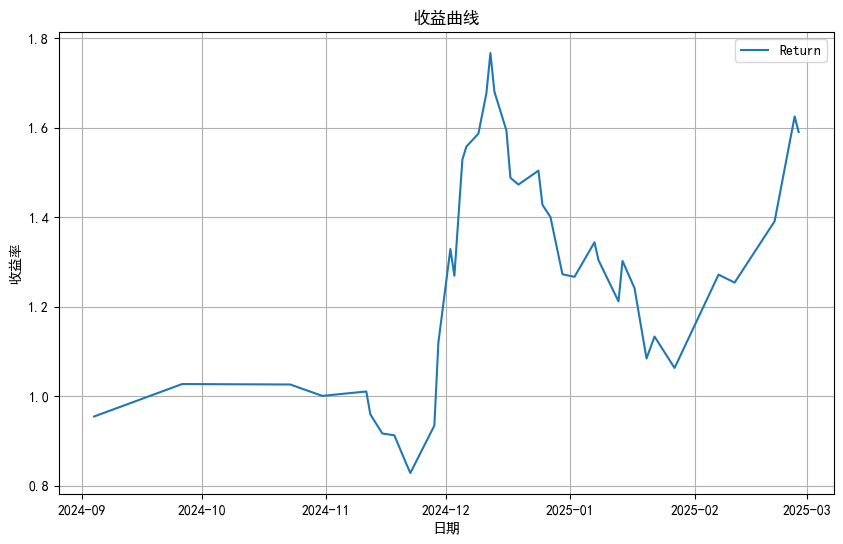

In [16]:
plot(ddwndx, 'cumulative_returns')

In [17]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

In [18]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-07,384,低吸,中位孕线低吸,002397.XSHE,梦洁股份,1,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,773.22,513.57,0.0,-0.53,3.74,4.14,-1.0,4.11,4.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-81.23,8.98,33,-39.67,1.00,26,2025-02-15 19:24:41,0.098930,0.097930,0.074866,0.073866,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.87,0.061016,1.344000,1.034759
2025-01-20,951,低吸,中位孕线低吸,600556.XSHG,天下秀,1,"000012.BKDL,000003.BKDL,000038.BKDL,000006.BKD...","885933.DDBK,885757.DDBK,883303.DDBK,886017.DDB...","980753.ZHBK,980355.ZHBK",2,1,5,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,88.19,180.04,0.0,-4.93,6.37,6.03,-1.0,5.70,5.43,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-2.10,-42.84,39,-31.54,-1.32,29,2025-02-15 19:35:40,-0.105181,-0.106181,-0.147567,-0.148567,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.52,-0.126767,1.084032,1.023548
2024-12-02,176,低吸,中位孕线低吸,002175.XSHE,东方智造,2,"000018.BKDL,000027.BKDL,000031.BKDL,000007.BKD...","885783.DDBK,885770.DDBK,885427.DDBK,885431.DDB...","980365.ZHBK,980355.ZHBK",1,1,5,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,3,0.0,79.43,151.07,0.0,-8.63,4.13,4.62,-1.0,4.99,5.08,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,30.46,80.39,32,15.41,2.55,52,2025-02-15 18:52:26,0.208232,0.207232,0.230024,0.229024,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.20,0.187095,1.328889,1.016949
2024-11-28,1766,低吸,中位孕线低吸,002582.XSHE,好想你,2,,,,-1,-1,-1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,286.84,352.64,0.0,-1.50,7.24,8.09,-1.0,8.30,8.39,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-75.80,18.53,68,-36.55,2.32,67,2025-02-15 18:49:58,0.146409,0.145409,0.158840,0.157840,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.35,0.128252,0.934230,1.015193
2025-02-26,3116,低吸,中位孕线低吸,603118.XSHG,共进股份,2,"000012.BKDL,000003.BKDL,000026.BKDL,000006.BKD...","885840.DDBK,885843.DDBK,885459.DDBK,886009.DDB...",980376.ZHBK,1,1,37,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,81.42,200.51,0.0,-1.12,12.34,13.31,-1.0,14.64,14.64,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,91.88,-6.50,6,53.62,-0.05,11,2025-02-28 17:32:36,0.186386,0.185386,0.186386,0.185386,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12.52,0.168329,1.625244,1.014587
2024-11-29,1815,低吸,中位孕线低吸,002193.XSHE,如意集团,3,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,50.10,210.35,0.0,-0.38,5.30,5.85,-1.0,6.44,6.44,-1.0,-1.0,-1.0,-1.0,0,0,9G0085,中位孕线低吸,-49.93,25.87,57,-12.49,20.53,64,2025-02-15 18:51:10,0.215094,0.214094,0.215094,0.214094,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.37,0.198255,1.119446,1.013208
2024-11-22,1416,低吸,中位孕线低吸,002181.XSHE,粤传媒,2,"000012.BKDL,000038.BKDL,000023.BKDL,000010.BKD...","886021.DDBK,886060.DDBK,885521.DDBK,885580.DDB...","980353.ZHBK,980355.ZHBK,980348.ZHBK",2,1,42,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,41.08,190.40,0.0,-2.89,4.70,4.54,-1.0,4.65,